<center>Progetto realizzato da Elena Curti (matr. 185431)

# Sentiment analysis – Amazon reviews
</center>

## Introduzione
... realizzato con MongoDB ... 


In [1]:
# !pip install happiestfuntokenizing

In [40]:
import nltk
import random
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment.util import mark_negation, extract_unigram_feats
from nltk.corpus import wordnet as wn
from pymongo import MongoClient
from happiestfuntokenizing.happiestfuntokenizing import Tokenizer
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.pipeline import Pipeline
from nltk.sentiment.sentiment_analyzer import SentimentAnalyzer


client = MongoClient('192.168.202.128', 27017)      # TODO mettere localhost
db = client.test

In [3]:
import os, sys

class HiddenPrints:
    """ Classe usata per evitare alcune print """
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


In [34]:
def getReviewData(database,  lista_overall, limite=1000, field="reviewText", funzione_tokenize=None):
    reviews = []
    for overall in lista_overall:
        for review in database.reviews.find({"overall": overall}).limit(limite):
            if funzione_tokenize == None:
                reviews.append((review[field],str(overall))) 
            else:
                reviews.append(([i.lower() for i in funzione_tokenize(review[field])],str(overall))) 
            
    random.shuffle(reviews) 
    return reviews  

def perform_cross_validation(classifier, train_set):
    data = [i for (i, _) in train_set]
    target = [j for (_, j) in train_set]
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    scores = train_test_split(classifier, data, target)
    return sum(scores)/len(scores)
   
def get_classifier_and_sentiment_analyzer(reviews, unigramFeats=[]):
    sentimAnalyzer = SentimentAnalyzer()
    allWordsNeg = sentimAnalyzer.all_words([mark_negation(doc) for doc in reviews])    
    
    if unigramFeats == []:
        unigramFeats = sentimAnalyzer.unigram_word_feats(allWordsNeg, min_freq=4)   
    sentimAnalyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigramFeats)
    featureSets = sentimAnalyzer.apply_features(reviews)

    # print(len(featureSets))
    
    dim = 100 #int(len(reviews)/3)-1
    accuracy = []
    get_random_item_from_featureset = lambda : [featureSets[random.randrange(len(featureSets))] for _ in range(dim)]
    
    for i in range(50):
        trainSet, testSet = get_random_item_from_featureset() , get_random_item_from_featureset() #random.sample(list(featureSets), dim)# featureSets[dim:], featureSets[:dim]
        # trainSet, testSet = featureSets[dim:], featureSets[:dim]  
        with HiddenPrints():
            classifier = sentimAnalyzer.train(NaiveBayesClassifier.train, trainSet)
            evalu = sentimAnalyzer.evaluate(testSet)
        accuracy.append(evalu["Accuracy"])
    
    return classifier, round(sum(accuracy)/len(accuracy), 2) #perform_cross_validation(classifier, trainSet) #dict(sorted(sentimAnalyzer.evaluate(testSet).items()))
    # else:
    #     dev_test = [ (reviews[i][0], featureSets[i][0], featureSets[i][1]) for i in range(dim,len(reviews)-dim)]
    #     return classifier, dev_test

def print_accuracy(diz):
    print("Accuracy:", diz["Accuracy"])

    return
    for key,value in list_items:
        print('{0}: {1}'.format(key, value))

## Versione 1 (originale): World tokenizer di nltk con due classi

In [5]:
# TODO rimuovi commenti
reviews1 = getReviewData(db, [1.0, 5.0], funzione_tokenize=nltk.word_tokenize)
classifier1, accuracy1 = get_classifier_and_sentiment_analyzer(reviews1)
print(accuracy1)

0.69


## Versione 2: Sentiment tokenizer di Christopher Potts con due classi

In [6]:
reviews2 = getReviewData(db, [1.0, 5.0], funzione_tokenize=Tokenizer().tokenize)
classifier2, accuracy2 = get_classifier_and_sentiment_analyzer(reviews2)
print(accuracy2)

0.7


## Versione 3: Classificazione a cinque classi

In [7]:
# TODO rimuovi limite di 100 
reviews3 = getReviewData(db, [float(i) for i in range(1,6)],limite=100, funzione_tokenize=nltk.word_tokenize)
classifier3, accuracy3 = get_classifier_and_sentiment_analyzer(reviews3)
print(accuracy3)

0.39


## Confronto tra le versioni
L'accuracy migliore è stata ottenuta con il sentiment tokenizer di Christopher Potts (<MARK>METTERE VALORE MEDIO</mark>). <br>
L'accuracy peggiore, invece, è stata ottenuta con la versione a cinque classi  (<MARK>METTERE VALORE MEDIO</mark>). <br>
L'accuracy della versione originale a due classi con nltk è a metà tra le due precedenti  (<MARK>METTERE VALORE MEDIO</mark>). 

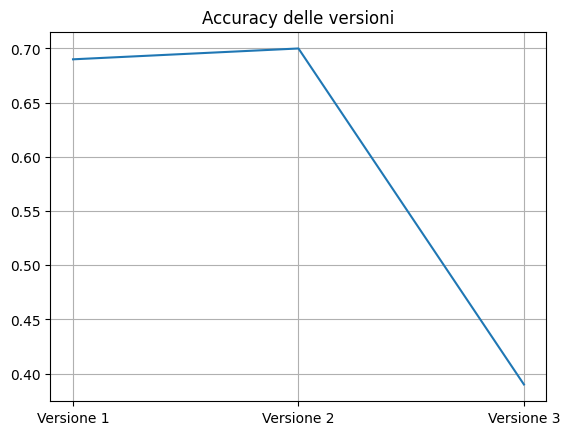

In [13]:
import matplotlib.pyplot as plt
x_plot = ["Versione 1", "Versione 2", "Versione 3"]
y_plot = [accuracy1, accuracy2, accuracy3]
plt.plot(x_plot, y_plot, label = "line 2")
plt.title('Accuracy delle versioni')
plt.grid()


## Cambio di feature
Per cercare di aumentare la accuracy, proverò ora a cambiare le feature.

### Versione 4: Uso del field "summary"

In [8]:
reviews4 = getReviewData(db, [1.0, 5.0],field="summary", funzione_tokenize=nltk.word_tokenize)
classifier4, accuracy4 = get_classifier_and_sentiment_analyzer(reviews4)
print(accuracy4)

0.68


### Versione 5: uso dei soli aggettivi

In [9]:
reviews5 = []
for (lista_parole,classe) in reviews1:
    solo_aggettivi = []
    for par in lista_parole:
        tmp = wn.synsets(par)
        if len(tmp) > 0 and tmp[0].pos() == "a":
            solo_aggettivi.append(par)
    if solo_aggettivi != []:
        reviews5.append((solo_aggettivi,classe)) 

classifier5, accuracy5 = get_classifier_and_sentiment_analyzer(reviews5)
print(accuracy5)

0.55


### Versione 6: uso della frequency word invece della occurrence
<mark> TODO

## Cambio di classificatore
Nelle versioni viste finora, ho sempre fatto uso del classificatore Naive Bayes di nltk. Proverò ora a modificarlo, per cercare di migliorare l'accuracy.

### Versione 7: classificatore Support Vector Machines (SVM)


In [43]:
# Creo il train e test set
reviews7 = getReviewData(db, [1.0, 5.0])
train_set, test_set = reviews7[100:], reviews7[:100]
train_data, train_target = list(map(list, zip(*train_set)))
test_data, test_target = list(map(list, zip(*test_set)))

# Classificatore
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),('clf', svm.SVC()),])
text_clf.fit(train_data, train_target)
predicted = text_clf.predict(test_data)

# Cross-validation
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
scores = cross_val_score(text_clf, test_data, test_target, cv=cv)
accuracy7 = round(sum(scores)/len(scores), 2)
print(accuracy7)


0.53
